# Load dataset from NarrativeQA

We use Narrative from Question Generation and RAG Evaluation

In [1]:
import pandas as pd
from Utils import *
data_loader = DatasetLoader()
from datasets import load_dataset
import os

vector_DB = VectorDatabase()
embedder = Embedder()
data_processor = DataProcessor(embedder=embedder, vectordatabase=vector_DB)

DatasetLoads initialized
Connected to Milvus at localhost:19530 with database default.
VectorDatabase initialized.
Initializing sparse embedder...
Embedder initialized
Data Processor initialized


[nltk_data] Downloading package words to /home/yarikama/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
def extract_narrativeqa_text(split='train'):
    # 載入數據集
    dataset = load_dataset("deepmind/narrativeqa", split=split)
    
    # 用於存儲唯一文本的字典
    unique_summaries = {}
    unique_documents = {}
    
    total_summary_chars = 0
    total_document_chars = 0
    
    # 用於存儲問題和答案的列表
    questions = []
    answers = []
    
    # 從每個示例中提取文本
    for example in dataset:
        summary = example['document']['summary']['text']
        document = example['document']['text']
        metadata = example['document']['kind'] + "\\" + example['document']['summary']['title']
        
        # 只有當摘要和文檔都是唯一的時才添加到 df_doc
        if summary not in unique_summaries and document not in unique_documents:
            unique_summaries[summary] = metadata
            unique_documents[document] = metadata
            total_summary_chars += len(summary)
            total_document_chars += len(document)
        
        # 總是添加問題和答案到 df_qa
        questions.append(example['question']['text'])
        answers_text = ""
        for answer in example['answers']:
            answers_text += answer['text'] + ", "
        answers.append(answers_text)
            
    # 從字典創建列表
    summaries = list(unique_summaries.keys())
    documents = list(unique_documents.keys())
    metadata = [unique_summaries[s] for s in summaries]  # 將元數據與摘要對齊
    
    # 計算平均值
    num_examples = len(summaries)
    avg_summary_chars = total_summary_chars / num_examples if num_examples > 0 else 0
    avg_document_chars = total_document_chars / num_examples if num_examples > 0 else 0
    
    # 創建 df_doc DataFrame
    df_doc = pd.DataFrame({
        'summary': summaries,
        'document': documents,
        'metadata': metadata
    })
    
    # 創建 df_qa DataFrame
    df_qa = pd.DataFrame({
        'questions': questions,
        'ground_truths': answers,
        'answers': ['' for _ in range(len(questions))],
        'context': ['' for _ in range(len(questions))]
    })
    
    print(f'唯一文檔數量: {num_examples}')
    print(f'問答對數量: {len(df_qa)}')
    print(f'平均摘要長度: {avg_summary_chars:.2f} 字符')
    print(f'平均文檔長度: {avg_document_chars:.2f} 字符')
    
    return df_doc, df_qa

In [ ]:
# df_doc, df_qa = extract_narrativeqa_text(split="train")
# df_doc.to_parquet(".parquet/narrative_qa_doc_full.parquet")
# df_qa.to_parquet(".parquet/narrative_qa_qa_full.parquet")
df_doc = pd.read_parquet(".parquet/narrative_qa_doc_full.parquet")
df_qa = pd.read_parquet(".parquet/narrative_qa_qa_full.parquet")

df_doc_sample = df_doc.sample(frac=0.01, random_state=42)
# df_qa_sample = df_qa.sample(frac=0.05, random_state=42)
df_doc_sample.to_parquet(".parquet/narrative_qa_doc_sample_11.parquet")
# df_qa_sample.to_parquet(".parquet/narrative_qa_qa_sample_11.parquet")
# df_doc_sample

In [ ]:
# load parquet
df_doc_sample = pd.read_parquet(".parquet/narrative_qa_doc_sample_11.parquet")



# Import Multihop Dataset

In [3]:
import pandas as pd
import json

def read_json_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = json.load(file)
    return dataset

def transform_to_dataframe(dataset):
    data_list = []
    for data in dataset:
        content = data["body"]
        metadata = {
            "title": data["title"],
            "source": data["source"],
            "published_at": data["published_at"]
        }
        data_list.append({"content": content, "metadata": metadata})
    
    return pd.DataFrame(data_list)

def transform_to_qa_dataframe(dataset):
    df_dataset = pd.DataFrame(dataset)    
    gold_lists = []
    for row in df_dataset["evidence_list"]:
        gold_list = []
        for evidence_list in row:
            gold_list.append({"fact": evidence_list["fact"], "source": evidence_list["source"], "url": evidence_list["url"], "title": evidence_list["title"]})            
        gold_lists.append(gold_list)
    df_dataset["gold_list"] = gold_lists
    df_dataset.drop(columns=["evidence_list"], inplace=True)
    df_dataset["retrieval_list"] = [[] for i in range(len(df_dataset))]
    df_dataset["model_answer"] = ["" for _ in range(len(df_dataset))]
    df_dataset["gold_answer"] = df_dataset["answer"]
    df_dataset.drop(columns=["answer"], inplace=True)
    
    return df_dataset

dataset = read_json_dataset("/home/yarikama/VGMARS/src/.dataset/multihop/MultiHopRAG.json")

df_dataset_multihop = transform_to_qa_dataframe(dataset)
df_dataset_multihop.to_parquet("/home/yarikama/VGMARS/src/.parquet/multihop_dataset.parquet")
df_dataset_multihop


,query,question_type,gold_list,retrieval_list,model_answer,gold_answer
0,Who is the individual associated with the cryp...,inference_query,"[{'fact': 'Before his fall, Bankman-Fried made...",[],,Sam Bankman-Fried
1,Which individual is implicated in both inflati...,inference_query,[{'fact': 'No apartment in New York City has e...,[],,Donald Trump
2,Who is the figure associated with generative A...,inference_query,[{'fact': 'Altman’s exit “is indeed shocking a...,[],,Sam Altman
3,Do the TechCrunch article on software companie...,comparison_query,[{'fact': 'They really just want to be able to...,[],,Yes
4,Which online betting platform provides a welco...,inference_query,[{'fact': 'New customers can get up to $1000 i...,[],,Caesars Sportsbook
...,...,...,...,...,...,...
2551,Who is the individual associated with using FT...,inference_query,"[{'fact': 'It was Bankman-Fried’s decision, sh...",[],,Sam Bankman-Fried
2552,Who is the individual that was once likened to...,inference_query,[{'fact': 'Bankman-Fried was even compared to ...,[],,Sam Bankman-Fried
2553,"Who, according to articles in Sporting News, s...",inference_query,[{'fact': 'If you bet $130 on the Cowboys and ...,[],,Bettors
2554,Does the Cnbc | World Business News Leader art...,comparison_query,"[{'fact': 'During cross-examination, Huang sai...",[],,Yes


In [6]:
retriever = Retriever(vector_DB)
retriever.hybrid_retrieve("multihop", ["Who is Sam Alterman?"])

# Transform the dataframe into .txts

In [2]:

import re
from bs4 import BeautifulSoup
import unicodedata

def preprocess_content(content: str) -> str:
    soup = BeautifulSoup(content, 'html.parser')
    text = soup.get_text()
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'[ \t]+', ' ', text).strip()
    text = re.sub(r'[^\w\s.,!?;:()"-]', '', text)
    text = text.replace('"', '"').replace('"', '"')
    text = re.sub(r'([.,!?;:])\1+', r'\1', text)
    text = re.sub(r'([.,!?;:])\s*', r'\1 ', text)

    return text.strip()

def write_text_to_files_by_metadata(df):
    # Ensure the dataframe has the required columns
    if not all(col in df.columns for col in ['content', 'metadata']):
        raise ValueError("Dataframe must contain 'document' and 'metadata' columns")

    os.makedirs(".txt/", exist_ok=True)
    
    # Dictionary to keep track of file handles
    file_handles = {}

    try:
        for _, row in df.iterrows():
            metadata = row['metadata']
            # content = preprocess_content(row['content'])
            content = row['content']
            filename = re.sub(r'[^\w\-\_\.]', '_', "-".join(metadata.values()))
            filename = f".txt/{filename}.txt"
            if metadata not in file_handles:
                file_handles[metadata] = open(filename, 'a', encoding='utf-8')

            # Write document to file
            file_handles[metadata].write(content + "\n")  # Add two newlines for separation

    finally:
        # Close all file handles
        print("close")
        for handle in file_handles.values():
            handle.close()

    print(f"{len(file_handles)} files have been created")

In [3]:
write_text_to_files_by_metadata(df_dataset)


# Embedder into Milvus (GPU) for txts

In [ ]:
data_processor.directory_files_process("narrative_qa_full_gpu", ".txt/", True, True)

# Import GRAPH RAG data to neo4j

In [7]:
knowledge_DB = KnowledgeGraphDatabase()

In [8]:
knowledge_DB.delete_all()

In [9]:
knowledge_DB.transform_graph_rag_to_neo4j(data_path="/home/yarikama/VGMARS/graph_rag_multihop/output/20240918-104951/artifacts")

In [7]:
retriever = Retriever()
retriever.local_retrieve_community_vector_search(["Who is Sam Alterman?"], 19)

# Test Modular RAG (Narrative QA)

In [5]:
import pandas as pd
rag_evaluation_dataset = pd.read_parquet(".parquet/narrative_qa_qa_sample_11.parquet")
dataset_queries = rag_evaluation_dataset["questions"].tolist()[15:20]
print(dataset_queries)
# print(vector_DB.list_collections())
answer = rag_evaluation_dataset["ground_truths"].tolist()[15:20]
print(answer)


['Why is Hal torn when he grows close to Mary Burke?', 'In what time period does the story end?', "Who is Blank's therapist?", 'What was the island called?', 'Who does Tom get a job with out West to help support his family?']
['He has a fiancee back home. because he has a fiancee back home ', 'The future A future time period. ', 'Dr. Oatman Dr. Oatman. ', 'Devil Island Devil Island ', 'Ned Ned ']


In [6]:
from Module import *
from Config.output_pydantic import *
from langchain_core.runnables.config import RunnableConfig
from IPython.display import Image


config = RunnableConfig(recursion_limit=1000000)
workflow = WorkFlowModularHybridRAG()

results = workflow.graph.stream({
    "dataset_queries": dataset_queries,
    "specific_collection": "narrative_qa_full_gpu",
}, config=config)

for result in results:
    print(result)


Image(workflow.graph.get_graph().draw_mermaid_png())



/opt/anaconda3/envs/poetry310/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


NameError: name 'WorkFlowModularHybridRAG' is not defined

In [ ]:
results["all_results"]

In [ ]:
answer

# Test Modular RAG (Multihop)

In [1]:
import pandas as pd
df_dataset_multihop = pd.read_parquet("/home/yarikama/VGMARS/src/.parquet/multihop_dataset.parquet")[750:800]
queries = df_dataset_multihop["query"].to_list()
queries

["Did the 'Sporting News' report on the Michigan sign-stealing scandal involving the Wolverines indicate a consistent or inconsistent portrayal of the situation compared to the earlier report by 'The New York Times' on the reactions of college football coaches to the alleged espionage?",
 "Between the TechCrunch report on Sam Altman's involvement with a teen's AI startup published on October 7, 2023, and the TechCrunch article suggesting doubts about Sam Altman's truthfulness with the board published on November 18, 2023, was there a change in the portrayal of Sam Altman's professional conduct?",
 'Considering the information from an article by The New York Times and another by The Guardian on the film "Dance The Night," which character, portrayed by an actor who has previously won an Academy Award, is central to the plot twist revealed in the third act of the movie as per The New York Times, and is also noted for their exceptional dance performance in a pivotal scene highlighted by Th

/opt/anaconda3/envs/poetry310/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)
2024-09-22 16:16:00,018 - 127034974098944 - milvus_client.py-milvus_client:658 - DEBUG: Created new connection using: ec8d4028051647839e19e75d4d6f7d75


Initializing sparse embedder...
Embedder initialized
Connected to Milvus at localhost:19530 with database default.
VectorDatabase initialized.
GraphDatabase initialized.
Retriever initialized
Agents initialized (with model: "gpt-4o-mini" and temperature: "0.1")
Tasks initialized
MultiAgent RAG System initialized


2024-09-22 16:16:00,551 - 127025637492416 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.


Query 0/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 97, 97, 97, 97, 96, 96, 95, 94, 94, 93, 85, 81, 81, 76, 70, 70, 56, 37, 25, 22]


2024-09-22 16:16:34,605 - 127025245324992 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 97, 97, 96, 96, 95, 93, 92, 92, 90, 90, 90, 88, 85, 84, 84, 79, 78, 78, 76, 73, 63, 60, 22]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 97, 97, 97, 97, 97, 97, 96, 96, 96, 96, 95, 95, 94, 94, 93, 93, 92, 92, 90, 90, 90, 88, 85, 85, 84, 84, 81, 81, 79, 78, 78, 76, 76, 73, 70, 70, 63, 60, 56]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:16:46,475 - 127024630859456 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:16:50,711 - 127025245324992 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:16:50,715 - 127025245324992 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 1/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 96, 95, 73, 69, 58, 34, 29]


2024-09-22 16:17:27,494 - 127024842671808 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 97, 97, 97, 96, 96, 96, 95, 91, 86, 83, 80, 79, 76, 74, 73, 70, 66, 56, 42, 39, 32, 31, 27]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 97, 97, 97, 96, 96, 96, 96, 95, 95, 91, 86, 83, 80, 79, 76, 74, 73, 73, 70, 69, 66, 58, 56]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:17:34,620 - 127025012541120 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:17:46,063 - 127025043998400 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:17:46,067 - 127025043998400 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 2/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:18:52,169 - 127025043998400 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["In 'Dance The Night', the central character, portrayed by an Academy Award-winning actor, is crucial to the plot twist revealed in the third act.", 'This character is recognized for their exceptional dance performance in a pivotal scene, which is a highlight noted by The Guardian.', "The character's journey culminates in a dramatic twist that is essential to the film's narrative, as emphasized by The New York Times."]
local scores: [51, 41, 37, 36, 35, 31, 29, 28, 24, 24]


2024-09-22 16:19:06,408 - 127025043998400 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:19:10,800 - 127025043998400 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:19:12,717 - 127025043998400 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:19:12,722 - 127025043998400 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 3/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 97, 96, 92, 90, 89, 82, 76, 75, 71, 69, 66, 61, 61, 39, 38, 36, 29, 28, 25, 22]


2024-09-22 16:19:39,985 - 127025023026880 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 97, 96, 92, 90, 89, 82, 76, 75, 71, 69, 66, 61, 61]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:19:45,413 - 127024005908160 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:19:47,912 - 127024662316736 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:19:47,916 - 127024662316736 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 4/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 97, 97, 93, 87, 74, 63, 54, 51, 43, 34, 28]


2024-09-22 16:20:16,555 - 127025054484160 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [67]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 97, 97, 93, 87, 74, 67, 63, 54, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:20:22,635 - 127023857010368 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:20:25,988 - 127025054484160 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:20:25,992 - 127025054484160 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 5/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:21:50,006 - 127025054484160 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ['The Guardian article suggests that Manchester United has been unsuccessful in their recent matches, particularly in their European campaign, which ended in disappointment.', 'In contrast to the Sporting News article, which implies that Manchester United has been eliminated from European competitions, the Guardian highlights their overall lack of success in recent matches.', 'Both articles indicate that Manchester United is facing significant challenges, with the Guardian focusing on their unsuccessful matches and the Sporting News confirming their elimination from Europe.', "The Guardian emphasizes Manchester United's struggles in recent matches, while the Sporting News confirms their exit from European competitions, showcasing a season of disappointment for the club.", "Overall, the Guardian suggests that Manchester United's recent matches have been unsuccessful

2024-09-22 16:22:04,747 - 127025054484160 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [96, 96, 92, 92, 91, 90, 89, 85, 80, 53, 26]
all scores: [99, 99, 99, 99, 98, 96, 96, 96, 92, 92, 91, 90, 89, 87, 86, 85, 82, 80, 71, 68, 53, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:22:13,430 - 127025054484160 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:22:16,021 - 127025054484160 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:22:16,026 - 127025054484160 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 6/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 94, 90, 88, 86, 83, 80, 78, 72, 70, 47, 46, 45, 33, 28, 28, 27]


2024-09-22 16:22:42,539 - 127024037365440 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 98, 97, 97, 96, 95, 94, 93, 93, 92, 86, 84, 44, 41, 39, 35, 23, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 96, 95, 94, 94, 93, 93, 92, 90, 88, 86, 86, 84, 83, 80, 78, 72, 70]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:22:50,405 - 127024651830976 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:22:51,699 - 127024832186048 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:22:51,703 - 127024832186048 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 7/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 89, 78, 68, 60, 43, 20]


2024-09-22 16:23:37,989 - 127024651830976 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 98, 97, 95, 94, 94, 91, 88, 88, 85, 72, 53, 53, 49, 48, 33]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 97, 95, 94, 94, 91, 89, 88, 88, 85, 78, 72, 68, 60, 53, 53]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:23:46,159 - 127024811214528 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:23:49,922 - 127023221573312 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:23:49,926 - 127023221573312 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 8/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 91, 84, 81, 78, 76, 49, 49, 45, 32]


2024-09-22 16:24:13,939 - 127024821700288 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 91, 84, 81, 78, 76]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:24:17,116 - 127025033512640 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:24:18,119 - 127025033512640 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:24:18,123 - 127025033512640 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 9/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 97, 95, 95, 94, 91, 87, 86, 79, 73, 70, 47, 32, 26]


2024-09-22 16:25:03,749 - 127023454357184 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [97, 96, 96, 96, 94, 93, 90, 85, 83, 82, 71, 66, 64, 64, 61, 55, 53, 52, 39, 38, 36, 32, 24, 24, 21, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 97, 97, 96, 96, 96, 95, 95, 94, 94, 93, 91, 90, 87, 86, 85, 83, 82, 79, 73, 71, 70, 66, 64, 64, 61, 55, 53, 52]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:25:10,472 - 127023836038848 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:25:13,983 - 127023836038848 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:25:13,986 - 127023836038848 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 10/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:25:48,135 - 127023836038848 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["The article from The Verge discussing the Microsoft Elite Series 2 'Core' version mentions that it is a stripped-down version of the Xbox Elite Wireless Controller Series 2, offering fewer features at a lower price compared to the standard model.", 'According to the article, the Elite Series 2 Core lacks some premium features but is offered at a lower price, indicating a reduction in features.', 'The article on MacBook Pros does not provide specific information about price reductions for the new models, but it does mention the transition from the M2 model to the new M3 processor models.']
local scores: [99, 99, 99, 98, 93, 22]


2024-09-22 16:26:02,356 - 127023836038848 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 93, 92, 91, 86, 85, 80, 59, 58, 36, 35]
all scores: [99, 99, 99, 99, 99, 99, 98, 93, 93, 92, 91, 86, 85, 80, 59, 58]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:26:09,789 - 127023836038848 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:26:13,152 - 127023836038848 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:26:13,157 - 127023836038848 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 11/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 89, 84, 83, 76, 69, 59, 55]


2024-09-22 16:26:59,588 - 127022395295424 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 98, 98, 98, 98, 95, 95, 95, 93, 92, 91, 91, 91, 91, 90, 90, 87, 87, 87, 87, 85, 83, 80, 80, 79, 79, 78, 78, 74, 73, 69, 65, 63, 61, 60, 57, 55, 54, 53, 49, 49, 43, 32, 30, 28, 27, 26, 25, 25, 24, 22, 21, 21]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 97, 97, 95, 95, 95, 93, 92, 91, 91, 91, 91, 90, 90, 89, 87, 87, 87, 87, 85, 84, 83, 83, 80, 80, 79, 79, 78, 78, 76, 74, 73, 69, 69, 65, 63, 61, 60, 59, 57, 55, 55, 54, 53]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:27:11,566 - 127023221573312 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:27:14,078 - 127023221573312 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:27:14,082 - 127023221573312 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 12/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 97, 95, 95, 95, 94, 92, 91, 91, 91, 90, 82, 80, 73, 69, 67, 63, 59, 56, 51, 49, 43, 37, 21]


2024-09-22 16:27:54,282 - 127022045071040 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 91, 75, 74, 71, 50, 45]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 97, 95, 95, 95, 94, 92, 91, 91, 91, 91, 90, 82, 80, 75, 74, 73, 71, 69, 67, 63, 59, 56, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:28:01,033 - 127023836038848 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:28:03,489 - 127024832186048 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:28:03,492 - 127024832186048 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 13/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 97, 96, 86, 85, 84, 77, 63, 61, 49, 28, 24]


2024-09-22 16:28:52,656 - 127021631932096 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 96, 95, 95, 94, 93, 89, 89, 89, 86, 82, 81, 74, 72, 70, 70, 68, 67, 63, 51, 45, 43, 31, 30, 30, 21]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 97, 96, 96, 95, 95, 94, 93, 89, 89, 89, 86, 86, 85, 84, 82, 81, 77, 74, 72, 70, 70, 68, 67, 63, 63, 61, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:29:01,842 - 127023232059072 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:29:05,848 - 127024016393920 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:29:05,852 - 127024016393920 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 14/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 97, 97, 97, 96, 67, 40]


2024-09-22 16:29:28,870 - 127021843744448 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [65, 29]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 97, 97, 97, 96, 67, 65]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:29:34,492 - 127022426752704 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:29:37,520 - 127022426752704 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:29:37,524 - 127022426752704 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 15/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 94, 93, 87, 53, 33, 20, 20]


2024-09-22 16:30:13,722 - 127023645198016 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 98, 74, 70, 65, 63, 60, 60, 54, 53, 52, 47, 46, 46, 44, 42, 39, 38, 34, 34, 34, 32, 30, 29, 27, 27, 22, 22, 22, 21, 20]
all scores: [99, 99, 99, 99, 99, 98, 94, 93, 87, 74, 70, 65, 63, 60, 60, 54, 53, 53, 52]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:30:22,835 - 127021229278912 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:30:26,256 - 127021229278912 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:30:26,261 - 127021229278912 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 16/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:30:53,442 - 127021229278912 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["The 'Essentially Sports' article claims that Canelo Alvarez has a specific net worth figure of 180 million dollars in 2023, while the 'CBSSports.com' article focuses on the fan base's perception of David Benavidez as a successor to Canelo Alvarez, without mentioning any financial figures.", "According to the 'Essentially Sports' article, Canelo Alvarez's net worth in 2023 is stated to be 180 million dollars, contrasting with the 'CBSSports.com' article that highlights David Benavidez's potential as Canelo's successor without discussing any financial aspects.", "Canelo Alvarez's net worth is reported to be 180 million dollars in 2023 by 'Essentially Sports', while 'CBSSports.com' emphasizes David Benavidez's standing as a future contender without addressing his financial status."]
local scores: [98, 98, 91, 86, 84, 83, 63, 51, 48, 30, 24, 21]


2024-09-22 16:31:09,353 - 127021229278912 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 98, 98, 94, 87, 82, 79, 36]
all scores: [99, 99, 98, 98, 98, 98, 94, 91, 87, 86, 84, 83, 82, 79, 63, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:31:18,526 - 127021229278912 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:31:21,069 - 127021229278912 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:31:21,074 - 127021229278912 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 17/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 95, 94, 93, 91, 83, 83, 63, 30, 23]


2024-09-22 16:31:47,922 - 127021801801408 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 98, 98, 97, 95, 94, 93, 91, 89, 82, 76, 57, 57, 46, 36, 27]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 97, 95, 95, 94, 94, 93, 93, 91, 91, 89, 83, 83, 82, 76, 63, 57, 57]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:31:54,811 - 127021239764672 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:31:58,449 - 127021229278912 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:31:58,453 - 127021229278912 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 18/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 96, 95, 92, 92, 90, 89, 88, 87, 86, 76, 72, 67, 67, 65, 64, 60, 54, 51, 46, 28, 23, 20, 20]


2024-09-22 16:32:34,471 - 127023221573312 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [66, 62, 53, 50, 47, 45, 44, 44, 39, 37, 29, 23, 22, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 96, 95, 92, 92, 90, 89, 88, 87, 86, 76, 72, 67, 67, 66, 65, 64, 62, 60, 54, 53, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:32:42,451 - 127022193968832 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:32:44,825 - 127021229278912 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:32:44,828 - 127021229278912 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 19/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 96, 90, 89, 88, 85, 81, 79, 79, 78, 57, 28, 27]


2024-09-22 16:33:04,780 - 127022204454592 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [98, 95, 95, 91, 89, 86, 73, 71, 59, 34, 28, 24, 22, 22, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 96, 95, 95, 91, 90, 89, 89, 88, 86, 85, 81, 79, 79, 78, 73, 71, 59, 57]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:33:12,835 - 127023200601792 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:33:16,897 - 127023200601792 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:33:16,902 - 127023200601792 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 20/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 96, 96, 95, 84, 79, 57, 33]


2024-09-22 16:33:44,968 - 127020826625728 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 92, 92, 91, 91, 89, 86, 76, 75, 73, 62, 39, 29, 24]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 96, 96, 95, 92, 92, 91,

2024-09-22 16:34:00,820 - 127022596622016 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:34:03,738 - 127023200601792 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:34:03,741 - 127023200601792 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 21/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 97, 97, 93, 89, 88, 87, 86, 83, 79, 79, 65, 46, 43, 39]


2024-09-22 16:34:37,431 - 127020403001024 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 97, 97, 95, 94, 91, 42, 35, 33, 30, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 97, 97, 97, 97, 95, 94, 93, 91, 89, 88, 87, 86, 83, 79, 79, 65]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:34:49,256 - 127020996495040 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:34:52,372 - 127020423972544 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:34:52,376 - 127020423972544 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 22/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:35:40,840 - 127020423972544 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ['The promotional offer reported as a first-time occurrence is the 20% statement credit for Delta SkyMiles® Gold Business American Express Card cardholders.', 'The discount on Sony WF-1000XM5 earbuds was part of a promotional event during Prime Day, but the 20% statement credit for Delta SkyMiles® Gold Business American Express Card cardholders is a new benefit.', 'The Delta SkyMiles Gold Business American Express Card introduced a 20% statement credit for cardholders, which is a first-time occurrence.', 'While the Sony WF-1000XM5 earbuds had a discount during Prime Day, the 20% statement credit for Delta SkyMiles® Gold Business American Express Card cardholders is reported as a first-time promotional offer.', 'The first-time occurrence reported is the 20% statement credit for Delta SkyMiles® Gold Business American Express Card cardholders, while the discount on So

2024-09-22 16:35:59,330 - 127020423972544 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 98, 98, 96, 96, 93, 90, 82, 67, 46]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 96, 96, 95, 94, 93, 93, 90, 83, 82, 74, 68, 67]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:36:07,146 - 127020423972544 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:36:09,014 - 127020423972544 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:36:09,018 - 127020423972544 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 23/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 94, 92, 91, 88, 64, 55, 35]


2024-09-22 16:36:35,630 - 127021239764672 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 98, 98, 97, 96, 96, 95, 94, 90, 89, 88, 87, 86, 77, 67, 60, 59, 53, 39, 36, 34, 34, 29, 29, 27, 24, 20, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 97, 96, 96, 95, 94, 94, 92, 91, 90, 89, 88, 88, 87, 86, 77, 67, 64, 60, 59, 55, 53]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:36:44,369 - 127021801801408 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:36:46,873 - 127022235911872 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:36:46,880 - 127022235911872 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 24/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 95, 82, 73, 60, 51]


2024-09-22 16:37:14,278 - 127021229278912 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [97, 96, 96, 95, 94, 94, 87, 86, 84, 82, 82, 75, 68, 68, 66, 65, 64, 52, 50, 42, 42, 37, 34, 33, 26, 25]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 97, 96, 96, 95, 95, 94, 94, 87, 86, 84, 82, 82, 82, 75, 73, 68, 68, 66, 65, 64, 60, 52, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:37:28,454 - 127019629151936 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:37:32,798 - 127021801801408 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:37:32,802 - 127021801801408 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 25/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:37:42,332 - 127021801801408 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["The Guardian reported on Eintracht Frankfurt's historic 5-1 victory over Bayern Munich, highlighting their impressive performance.", "Before 'The Independent - Sports' mentioned Joelinton's powerful goal for Newcastle, 'The Guardian' covered Eintracht Frankfurt's significant win.", "Eintracht Frankfurt's achievement against Bayern Munich was reported by 'The Guardian' prior to any mention of Joelinton's goal for Newcastle.", "In the context of Bundesliga achievements, 'The Guardian' focused on Eintracht Frankfurt's victory before discussing Joelinton's contributions to Newcastle."]
local scores: [99, 98, 97, 97, 97, 96, 95, 94, 93, 25, 21]


2024-09-22 16:37:54,335 - 127021801801408 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 97, 82, 80, 77, 75]
all scores: [99, 99, 99, 98, 97, 97, 97, 97, 96, 95, 94, 93, 82, 80, 77, 75]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:38:02,660 - 127021801801408 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:38:04,844 - 127021801801408 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:38:04,849 - 127021801801408 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 26/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 83, 75, 69, 68, 32]


2024-09-22 16:38:56,121 - 127019778049728 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 83, 75, 69, 68]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:39:01,830 - 127019174069952 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:39:04,625 - 127020233131712 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:39:04,629 - 127020233131712 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 27/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 94, 93, 92, 91, 88, 88, 83, 81, 71, 66, 64, 55, 53, 51, 25, 20]


2024-09-22 16:39:39,689 - 127020423972544 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [91, 34]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 94, 93, 92, 91, 91, 88, 88, 83, 81, 71, 66, 64, 55, 53, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:39:47,428 - 127019576723136 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:39:49,842 - 127019629151936 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:39:49,847 - 127019629151936 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 28/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 94, 93, 90, 87, 85, 83, 78, 72, 70, 69, 54, 53, 34, 21]


2024-09-22 16:40:24,445 - 127019406853824 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 94, 93, 90, 87, 85, 83, 78, 72, 70, 69, 54, 53]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:40:28,873 - 127019608180416 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:40:31,474 - 127020423972544 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:40:31,478 - 127020423972544 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 29/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 97, 95, 88, 85, 83, 82, 77, 71, 71, 55, 54, 53, 52, 51, 45, 44, 43, 42, 31, 27]


2024-09-22 16:40:58,872 - 127020212160192 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [96, 95, 88, 86, 83, 71, 71, 64, 57, 51, 48, 46, 38, 38, 31, 28, 23, 22, 21, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 97, 96, 95, 95, 88, 88, 86, 85, 83, 83, 82, 77, 71, 71, 71, 71, 64, 57, 55, 54, 53, 52, 51, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:41:08,167 - 127019597694656 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:41:11,155 - 127019597694656 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:41:11,159 - 127019597694656 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 30/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 94, 89, 87, 87]


2024-09-22 16:41:35,812 - 127020212160192 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 94, 93, 91, 85, 79, 75, 59, 38]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 94, 94, 93, 91, 89, 87, 87, 85, 79, 75, 59]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:41:45,494 - 127020233131712 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:41:48,661 - 127019618666176 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:41:48,666 - 127019618666176 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 31/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [94, 91, 54, 52]


2024-09-22 16:42:30,061 - 127022045071040 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 98, 97, 97, 97, 96, 96, 94, 92, 92, 92, 90, 90, 88, 87, 83, 83, 75, 72, 68, 64, 60, 58, 55, 54, 53, 47, 44, 42, 38, 36, 30, 23, 23]
all scores: [99, 99, 98, 97, 97, 97, 96, 96, 94, 94, 92, 92, 92, 91, 90, 90, 88, 87, 83, 83, 75, 72, 68, 64, 60, 58, 55, 54, 54, 53, 52]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:42:41,104 - 127018612033216 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:42:44,462 - 127020403001024 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:42:44,465 - 127020403001024 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 32/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:43:47,358 - 127020403001024 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ['The Engadget article suggests that Valve is launching the updated Steam Deck OLED on November 16.', 'The Verge article indicates that Valve has shifted its business strategy to focus exclusively on games for their store.']
local scores: [99, 93, 93, 35, 32]


2024-09-22 16:43:58,272 - 127020403001024 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 98, 98, 97, 97, 97, 88, 78, 28, 27]
all scores: [99, 99, 98, 98, 97, 97, 97, 93, 93, 88, 78]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:44:12,163 - 127020403001024 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:44:13,850 - 127020403001024 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:44:13,854 - 127020403001024 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 33/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 97, 97, 97, 95, 94, 93, 82, 77, 75, 70, 66, 56, 49, 22]


2024-09-22 16:44:42,564 - 127018612033216 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [98, 83, 79, 77, 73, 67, 55, 49, 38]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 97, 97, 97, 95, 94, 93, 83, 82, 79, 77, 77, 75, 73, 70, 67, 66, 56, 55]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:44:48,318 - 127019629151936 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:44:49,943 - 127019629151936 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:44:49,948 - 127019629151936 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 34/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:46:02,987 - 127019629151936 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ['The article from Sporting News mentions a foul on Luciano Acosta that resulted in a set-piece opportunity for Inter Miami, but there is no information about a similar interruption in the article from The Roar regarding Marcus Lee.', "While the Sporting News article discusses a foul leading to a free-kick for Inter Miami, the details about Marcus Lee's situation are not provided, making it unclear if they mention the same type of game interruption.", "Luciano Acosta's situation involved a foul that allowed for a free-kick, but without details from the article involving Marcus Lee, we cannot confirm if both articles discuss the same type of game interruption."]
local scores: [34, 31, 30]


2024-09-22 16:46:14,393 - 127019629151936 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: []
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:46:15,572 - 127019629151936 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:46:16,946 - 127019629151936 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:46:16,950 - 127019629151936 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 35/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 96, 95, 91, 90, 80, 79, 75, 70, 69, 68, 53, 49, 28, 26]


2024-09-22 16:46:44,888 - 127019629151936 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 91, 80, 78, 61, 58]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 96, 95, 91, 91, 90, 80, 80, 79, 78, 75, 70, 69, 68, 61, 58, 53]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:47:38,495 - 127017605400256 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:47:41,655 - 127017393587904 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:47:41,659 - 127017393587904 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 36/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:48:46,372 - 127017393587904 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["TechCrunch reported on Google's antitrust battle with Epic Games on November 6, 2024, highlighting the trial's focus on Google's alleged anticompetitive practices in the app store market.", "On December 15, 2023, TechCrunch also reported on a class action antitrust suit against Google, which may lead to an inconsistent portrayal of Google's legal challenges regarding anticompetitive behavior.", 'The reports from TechCrunch on both dates reflect ongoing legal scrutiny of Google, with the Epic Games case specifically addressing app store practices and the class action lawsuit covering broader antitrust issues.', "The inconsistent portrayal of Google's legal challenges could stem from the differing focuses of the reports, with one centered on Epic's specific claims and the other on a wider class action context."]
local scores: [99, 99, 99, 99, 99, 98, 98, 98, 98, 98

2024-09-22 16:49:02,415 - 127017393587904 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 96, 96, 95, 94, 79, 76, 63, 50, 50, 31]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 97, 97, 97, 96, 96, 96, 96, 96, 95, 94, 91, 91, 89, 79, 78, 77, 76, 74, 69, 63, 58, 52]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:49:09,956 - 127017393587904 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:49:14,465 - 127017393587904 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:49:14,469 - 127017393587904 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 37/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:49:40,412 - 127017393587904 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["The Sporting News article aligns with the report on Tyler Adams' absence due to a hamstring injury, as it confirms his ongoing injury status while also noting Johnny Cardoso's return to the USMNT squad after recovering from an ankle injury.", 'Yes, the Sporting News article states that Tyler Adams is absent from the USMNT due to a hamstring injury, while Johnny Cardoso has been included in the squad after recovering from an ankle injury.', 'The reports from the Sporting News are consistent; Tyler Adams is out with a hamstring injury, and Johnny Cardoso has returned to the squad after overcoming his ankle injury.']
local scores: [99, 99, 99, 99, 97, 95, 92, 88, 87, 59, 52, 41, 35, 24, 20]


2024-09-22 16:49:52,253 - 127017393587904 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 98, 98, 98]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 97, 95, 92, 88, 87, 59, 52]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:49:58,624 - 127017393587904 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:50:01,298 - 127017393587904 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:50:01,301 - 127017393587904 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 38/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 96, 90, 73, 59, 39, 31]


2024-09-22 16:50:34,465 - 127016365983424 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 97, 97, 97, 96, 95, 95, 94, 94, 93, 92, 92, 92, 91, 90, 83, 82, 81, 80, 77, 66, 66, 60, 56, 54, 51, 50, 49, 47, 45, 43, 41, 41, 36, 25, 23, 21]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 97, 97, 97, 96, 96, 95, 95, 94, 94, 93, 92, 92, 92, 91, 90, 90, 83, 82, 81, 80, 77, 73, 66, 66, 60, 59, 56, 54, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:50:43,732 - 127016959477440 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:50:46,894 - 127016365983424 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:50:46,899 - 127016365983424 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 39/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 96, 91, 62]


2024-09-22 16:51:42,817 - 127016365983424 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 94, 94, 84, 80, 79, 75, 73, 57, 52, 48, 33, 33, 32, 31, 27, 25]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 96, 94, 94, 91, 84, 80, 79, 75, 73, 62, 57, 52]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:51:50,170 - 127016407926464 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:51:53,415 - 127017573942976 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:51:53,418 - 127017573942976 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 40/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 97, 97, 97, 97, 97, 97, 96, 96, 96, 96, 96, 96, 95, 94, 94, 94, 94, 94, 92, 92, 92, 91, 90, 89, 89, 89, 88, 87, 85, 82, 81, 73, 70, 65, 60, 53, 48, 44, 43, 41, 40, 40, 40, 39, 38, 32, 31, 31, 31, 29, 27, 26, 24, 21, 20, 20]


2024-09-22 16:52:20,962 - 127017573942976 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 97, 97, 97, 97, 97, 97, 96, 96, 96, 96, 96, 96, 95, 94, 94, 94, 94, 94, 92, 92, 92, 91, 90, 89, 89, 89, 88, 87, 85, 82, 81, 73, 70, 65, 60, 53]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:52:25,986 - 127016588281536 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:52:31,587 - 127016588281536 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:52:31,591 - 127016588281536 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 41/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 97, 97, 92, 92, 92, 91, 86, 84, 65, 61, 61, 56, 56, 54, 51, 49, 48, 48, 47, 41, 40, 40, 35, 35, 27, 27, 26]


2024-09-22 16:53:04,318 - 127016990934720 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 97, 96, 96, 94, 94, 88, 86, 86, 84, 74]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 97, 97, 97, 96, 96, 94, 94, 92, 92, 92, 91, 88, 86, 86, 86, 84, 84, 74, 65, 61, 61, 56, 56, 54, 51]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:53:16,432 - 127015581648576 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:53:19,921 - 127016598767296 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:53:19,924 - 127016598767296 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 42/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 96, 95, 83, 81, 79, 74]


2024-09-22 16:53:48,472 - 127015401293504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [95, 89, 86, 76, 74, 63, 41, 30]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 96, 95, 95, 89, 86, 83, 81, 79, 76, 74, 74, 63]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:53:56,728 - 127017001420480 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:53:58,761 - 127016185628352 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:53:58,764 - 127016185628352 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 43/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:55:20,311 - 127016185628352 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["The Queensland Rugby Union is attempting to centralize Super Rugby's high-performance programs and is supported by franchises for a potential coaching appointment.", 'The QRU is urging Rugby Australia to reinstate the annual funding to Super Rugby franchises that was cut during the pandemic.', 'Rugby Australia is moving closer to appointing Peter Horne as the new director of high-performance, which could lead to Joe Schmidt being appointed as the Wallabies coach.']
local scores: [99, 99]


2024-09-22 16:55:32,764 - 127016185628352 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 98, 93, 85, 74, 41, 36, 23]
all scores: [99, 99, 99, 99, 99, 99, 99, 98, 93, 85, 74]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:55:41,217 - 127016185628352 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:55:43,384 - 127016185628352 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:55:43,388 - 127016185628352 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 44/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 97, 97, 97, 96, 96, 96, 95, 94, 93, 92, 92, 92, 90, 88, 87, 82, 80, 77, 71, 68, 66, 66, 65, 63, 45, 44, 43, 42, 38, 34, 31, 29, 26, 23]


2024-09-22 16:56:14,392 - 127015994787520 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 92, 82, 80, 77, 70, 57, 56, 52, 39, 35, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 97, 97, 97, 96, 96, 96, 95, 94, 93, 92, 92, 92, 92, 90, 88, 87, 82, 82, 80, 80, 77, 77, 71, 70, 68, 66, 66, 65, 63, 57, 56, 52]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:56:22,481 - 127015390807744 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:56:25,262 - 127016609253056 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:56:25,266 - 127016609253056 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 45/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:56:29,182 - 127016609253056 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["The portrayal of Prince William's reaction to Princess Diana's death in 'The Crown season six' remains consistent with the depiction mentioned in the later article by The Independent, as both highlight his grief and emotional turmoil.", "In both articles from The Independent, Prince William's reaction is depicted as heart-wrenching, reflecting the profound impact of his mother's death on him.", "The Crown's depiction of William's emotional state after Diana's death aligns with the later article's portrayal, emphasizing his heartbreak and anger during that tragic time.", "Both reports from The Independent illustrate the devastating effect of Diana's death on Prince William, showcasing his struggle with grief and the family's response to the tragedy.", "The emotional portrayal of Prince William in 'The Crown season six' is consistent with the later article, as both

2024-09-22 16:56:46,243 - 127016609253056 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 97, 97, 95, 93, 92, 91, 91, 79, 76, 75, 73, 67]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:57:10,096 - 127016609253056 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:57:13,142 - 127016609253056 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:57:13,147 - 127016609253056 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 46/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 88, 64, 50, 33, 28]


2024-09-22 16:57:44,886 - 127014956697280 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 97, 96, 94, 90, 80, 64, 64, 49, 45, 42, 40, 37, 35, 32, 26]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 97, 96, 94, 90, 88, 80, 64, 64, 64]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:58:00,051 - 127014765856448 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:58:04,120 - 127014956697280 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:58:04,124 - 127014956697280 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 47/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 68, 48, 43, 40, 37, 20]


2024-09-22 16:58:33,224 - 127014765856448 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 97, 97, 97, 97, 96, 96, 96, 96, 95, 95, 95, 95, 95, 95, 95, 94, 92, 90, 90, 90, 90, 90, 89, 89, 85, 84, 83, 81, 80, 79, 78, 76, 73, 63, 61, 50, 46, 30, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 97, 97, 97, 97, 97, 96, 96, 96, 96, 95, 95, 95, 95, 95, 95, 95, 94, 92, 90, 90, 90, 90, 90, 89, 89, 85, 84, 83, 81, 80, 79, 78, 76, 73, 68, 63, 61]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:58:45,824 - 127014352717504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:58:47,569 - 127015401293504 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:58:47,574 - 127015401293504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 48/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 96, 96, 94, 91, 89, 83, 79, 69, 54, 47, 34, 34]


2024-09-22 16:59:18,518 - 127015581648576 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [83, 68, 66, 54, 43, 39, 32, 30, 26, 23]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 96, 96, 94, 91, 89, 83, 83, 79, 69, 68, 66, 54, 54]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 16:59:31,601 - 127014946211520 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-22 16:59:34,667 - 127016758150848 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-22 16:59:34,671 - 127016758150848 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 49/50
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 96, 95, 64, 59, 47, 46, 44, 44]


2024-09-22 17:00:04,373 - 127016386954944 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 98, 98, 98, 97, 96, 94, 94, 94, 93, 93, 90, 88, 79, 69, 68, 65, 57, 30, 21, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 97, 96, 96, 95, 94, 94, 94, 93, 93, 90, 88, 79, 69, 68, 65, 64, 59, 57]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-22 17:00:10,314 - 127014956697280 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


dataset_queries
user_query
specific_collection
generation_result
information_organization_result
detailed_search_result
possible_answers
all_generation_results
all_information_contexts
all_vectordatabase_contexts
all_graphdatabase_contexts
all_possible_answers


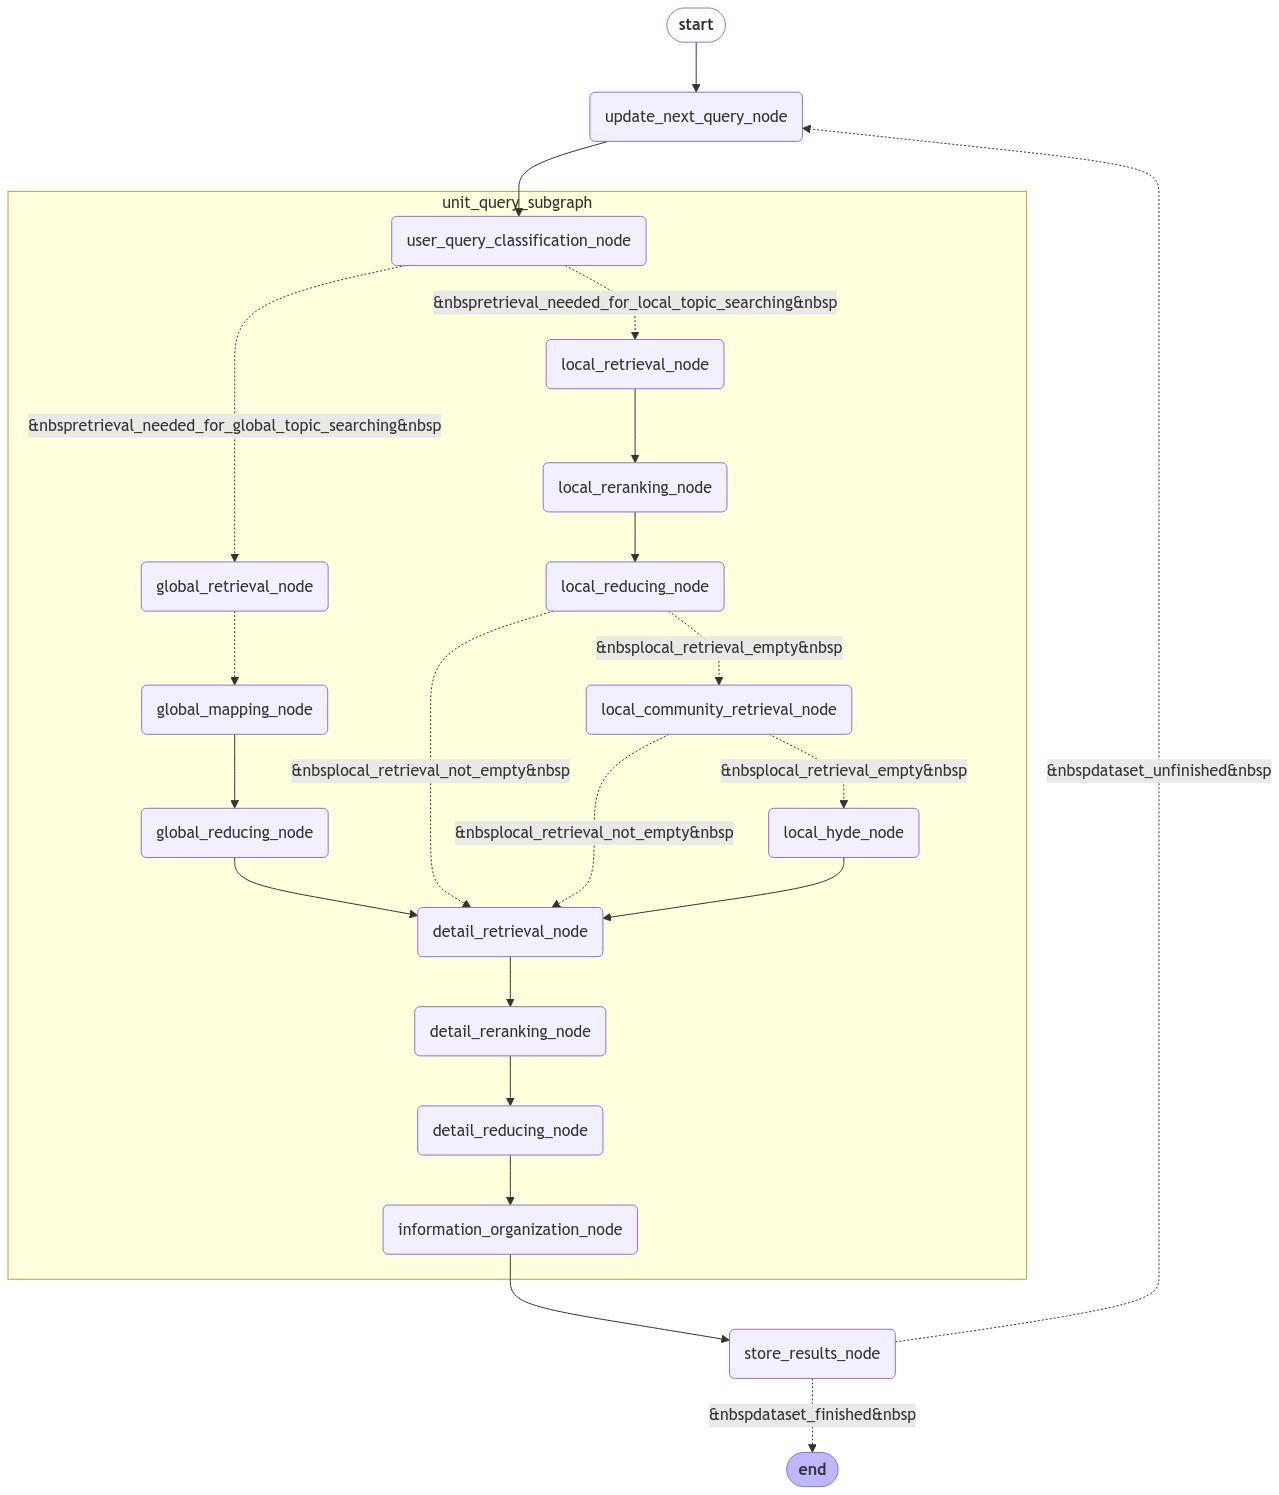

In [2]:
from Module import *
from Config.output_pydantic import *
from langchain_core.runnables.config import RunnableConfig
from IPython.display import Image

config = RunnableConfig(recursion_limit=1000000)
workflow = DatasetRecord()

results = workflow.graph.invoke({
    "dataset_queries": queries,
    "specific_collection": "multihop",
}, config=config)

for result in results:
    print(result)
    
Image(workflow.graph.get_graph(xray=1).draw_mermaid_png())


In [3]:
df_dataset_multihop["model_answer"] = results["all_generation_results"]
df_dataset_multihop["organized_information"] = results["all_information_contexts"]
df_dataset_multihop["retrieval_list"] = results["all_vectordatabase_contexts"]
df_dataset_multihop["possible_answers"] = results["all_possible_answers"]
df_dataset_multihop["all_graphdatabase_contexts"] = results["all_graphdatabase_contexts"]
df_dataset_multihop.to_json("/home/yarikama/VGMARS/src/.dataset/multihop/result_sample_10.json", orient="records", indent=4)
df_dataset_multihop = df_dataset_multihop[df_dataset_multihop["gold_answer"] != "Insufficient information."]
df_dataset_multihop

,query,question_type,gold_list,retrieval_list,model_answer,gold_answer,organized_information,possible_answers,all_graphdatabase_contexts
750,Did the 'Sporting News' report on the Michigan...,temporal_query,"[{'fact': 'For the past two weeks, coaches acr...",[{'text': 'The Sporting News is tracking the l...,**Short Answer:** The reports from 'Sporting N...,Consistent,[The community centers around the Michigan Wol...,[Did the 'Sporting News' report on the Michiga...,[The community information does not provide di...
751,Between the TechCrunch report on Sam Altman's ...,temporal_query,[{'fact': 'In the year since Altman catapulted...,[{'text': 'Altman has been telling investors t...,"Yes, there was a significant change in the por...",Yes,[1. The TechCrunch report on Sam Altman's invo...,[Between the TechCrunch report on Sam Altman's...,[The TechCrunch report on Sam Altman's involve...
753,"Which company, covered by The Verge and TechCr...",inference_query,[{'fact': 'Google’s public documentation says ...,[],**Short Answer:** The company is Mapstead. \n...,Google,[The user query pertains to a company that has...,"[Which company, covered by The Verge and TechC...",[The user query pertains to a company that has...
754,Does the article from The Age suggest that 'Pe...,comparison_query,[{'fact': 'Lucashenko says there’s a “whole de...,[{'text': 'Advertisement Lucashenko says there...,"Short Answer: No, the article from The Age doe...",no,[The Age article discusses the complexities of...,[Does the article from The Age suggest that 'P...,[The community information does not directly a...
755,Does 'The Guardian' article suggest that Manch...,comparison_query,"[{'fact': 'United have been so of late, claimi...",[{'text': ''We've lost decisive players': Ten ...,"Yes, 'The Guardian' article suggests that Manc...",no,[Manchester United's European campaign has bee...,[Does 'The Guardian' article suggest that Manc...,[Manchester United's European campaign has bee...
756,Does the article from The Verge defending Appl...,comparison_query,[{'fact': '“Certainly there wasn’t a valid alt...,[{'text': 'wasn’t a valid alternative to Googl...,"Yes, the article from The Verge defending Appl...",Yes,[The Verge article defending Apple's Google Se...,[Does the article from The Verge defending App...,[The Verge article defending Apple's Google Se...
757,"Between the TechCrunch article on December 7, ...",temporal_query,[{'fact': 'Google compared the performance of ...,"[{'text': 'This week, Google took the wraps of...","No, there was inconsistency in the reporting o...",Yes,"[The TechCrunch article on December 7, 2023, d...","[Between the TechCrunch article on December 7,...","[The TechCrunch article on December 7, 2023, d..."
759,Which company has been accused of both manipul...,inference_query,[{'fact': 'She admits that she may have misint...,[{'text': 'article by lawyer and privacy advoc...,"Yes, the company that has been accused of mani...",Google,[Google has been accused of manipulating its s...,[Which company has been accused of both manipu...,[The user query involves a company accused of ...
760,Does the article from The Verge discussing the...,comparison_query,[{'fact': 'Microsoft also has a stripped-down ...,[{'text': 'Design Lab “Elite Package.”) Micros...,"Yes, the article from The Verge discussing the...",Yes,[The article from The Verge discussing the Mic...,[Does the article from The Verge discussing th...,[The Elite Series 2 Core is a variant of the X...
761,"Who is the individual that, prior to the FTX c...",inference_query,"[{'fact': 'Before his fall, Bankman-Fried made...","[{'text': 'Before his fall, Bankman-Fried made...",The individual you are referring to is Sam Ban...,Sam Bankman-Fried,"[Prior to the FTX collapse, Sam Bankman-Fried ...","[Who is the individual that, prior to the FTX ...","[Prior to the FTX collapse, there was a credib..."


# Use RAGAS to Evaluate Multihop

In [4]:
ragas_multihop = pd.DataFrame({
    "question": df_dataset_multihop["query"],
    "answer": df_dataset_multihop["model_answer"],
    "contexts": df_dataset_multihop["organized_information"],
    "ground_truth": df_dataset_multihop["gold_answer"]
})
ragas_multihop

,question,answer,contexts,ground_truth
750,Did the 'Sporting News' report on the Michigan...,**Short Answer:** The reports from 'Sporting N...,[The community centers around the Michigan Wol...,Consistent
751,Between the TechCrunch report on Sam Altman's ...,"Yes, there was a significant change in the por...",[1. The TechCrunch report on Sam Altman's invo...,Yes
753,"Which company, covered by The Verge and TechCr...",**Short Answer:** The company is Mapstead. \n...,[The user query pertains to a company that has...,Google
754,Does the article from The Age suggest that 'Pe...,"Short Answer: No, the article from The Age doe...",[The Age article discusses the complexities of...,no
755,Does 'The Guardian' article suggest that Manch...,"Yes, 'The Guardian' article suggests that Manc...",[Manchester United's European campaign has bee...,no
756,Does the article from The Verge defending Appl...,"Yes, the article from The Verge defending Appl...",[The Verge article defending Apple's Google Se...,Yes
757,"Between the TechCrunch article on December 7, ...","No, there was inconsistency in the reporting o...","[The TechCrunch article on December 7, 2023, d...",Yes
759,Which company has been accused of both manipul...,"Yes, the company that has been accused of mani...",[Google has been accused of manipulating its s...,Google
760,Does the article from The Verge discussing the...,"Yes, the article from The Verge discussing the...",[The article from The Verge discussing the Mic...,Yes
761,"Who is the individual that, prior to the FTX c...",The individual you are referring to is Sam Ban...,"[Prior to the FTX collapse, Sam Bankman-Fried ...",Sam Bankman-Fried


In [5]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)
ragas_multihop_evaluation = Dataset.from_pandas(ragas_multihop)
result = evaluate(
    dataset = ragas_multihop_evaluation, 
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
    ],
)

df = result.to_pandas()
df

Evaluating:   0%|          | 0/184 [00:00<?, ?it/s]

,question,answer,contexts,ground_truth,__index_level_0__,faithfulness,answer_relevancy,context_precision,context_recall
0,Did the 'Sporting News' report on the Michigan...,**Short Answer:** The reports from 'Sporting N...,[The community centers around the Michigan Wol...,Consistent,750,0.863636,0.948091,0.500000,0.909091
1,Between the TechCrunch report on Sam Altman's ...,"Yes, there was a significant change in the por...",[1. The TechCrunch report on Sam Altman's invo...,Yes,751,1.000000,0.918826,0.926667,1.000000
2,"Which company, covered by The Verge and TechCr...",**Short Answer:** The company is Mapstead. \n...,[The user query pertains to a company that has...,Google,753,0.869565,0.963307,0.125000,0.500000
3,Does the article from The Age suggest that 'Pe...,"Short Answer: No, the article from The Age doe...",[The Age article discusses the complexities of...,no,754,1.000000,0.978770,0.835714,1.000000
4,Does 'The Guardian' article suggest that Manch...,"Yes, 'The Guardian' article suggests that Manc...",[Manchester United's European campaign has bee...,no,755,0.947368,0.954839,0.679167,1.000000
5,Does the article from The Verge defending Appl...,"Yes, the article from The Verge defending Appl...",[The Verge article defending Apple's Google Se...,Yes,756,1.000000,0.931655,0.876190,1.000000
6,"Between the TechCrunch article on December 7, ...","No, there was inconsistency in the reporting o...","[The TechCrunch article on December 7, 2023, d...",Yes,757,0.888889,0.926353,0.609758,1.000000
7,Which company has been accused of both manipul...,"Yes, the company that has been accused of mani...",[Google has been accused of manipulating its s...,Google,759,0.850000,0.903689,0.733333,1.000000
8,Does the article from The Verge discussing the...,"Yes, the article from The Verge discussing the...",[The article from The Verge discussing the Mic...,Yes,760,0.954545,0.962369,0.000000,1.000000
9,"Who is the individual that, prior to the FTX c...",The individual you are referring to is Sam Ban...,"[Prior to the FTX collapse, Sam Bankman-Fried ...",Sam Bankman-Fried,761,0.909091,0.799188,0.871111,1.000000


In [6]:
avg_context_precision = df["context_precision"].mean()
avg_context_recall = df["context_recall"].mean()
avg_faithfulness = df["faithfulness"].mean()
avg_answer_relevancy = df["answer_relevancy"].mean()

print(f"Average context precision: {avg_context_precision}")
print(f"Average context recall: {avg_context_recall}")
print(f"Average faithfulness: {avg_faithfulness}")
print(f"Average answer relevancy: {avg_answer_relevancy}")


Average context precision: 0.6639797060307778
Average context recall: 0.854045109479892
Average faithfulness: 0.8737121141628374
Average answer relevancy: 0.8419287428258349


In [3]:
import pandas as pd
df_dataset_multihop = pd.read_parquet("/home/yarikama/VGMARS/src/.parquet/multihop_dataset.parquet")[0:3]
queries = df_dataset_multihop["query"].to_list()
queries

['Who is the individual associated with the cryptocurrency industry facing a criminal trial on fraud and conspiracy charges, as reported by both The Verge and TechCrunch, and is accused by prosecutors of committing fraud for personal gain?',
 "Which individual is implicated in both inflating the value of a Manhattan apartment to a figure not yet achieved in New York City's real estate history, according to 'Fortune', and is also accused of adjusting this apartment's valuation to compensate for a loss in another asset's worth, as reported by 'The Age'?",
 'Who is the figure associated with generative AI technology whose departure from OpenAI was considered shocking according to Fortune, and is also the subject of a prevailing theory suggesting a lack of full truthfulness with the board as reported by TechCrunch?']

In [4]:
from Module import *
from Config.output_pydantic import *
from langchain_core.runnables.config import RunnableConfig
from IPython.display import Image

config = RunnableConfig(recursion_limit=1000000)
workflow = ParallelDatasetRecord()

results = workflow.graph.invoke({
    "dataset_queries": queries,
    "dataset_specific_collection": "multihop",
}, config=config)

for result in results:
    print(result)
    
Image(workflow.graph.get_graph(xray=1).draw_mermaid_png())


2024-09-23 07:57:41,784 - 129054751590080 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-23 07:57:41,784 - 129054741104320 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-23 07:57:41,793 - 129054720132800 - base.py-base:957 - WARNING: CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
2024-09-23 07:57:41,800 - 129054720132800 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-23 07:57:41,802 - 129054751590080 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


{'prepare_batches_node': {'batches': [{'user_query': 'Who is the individual associated with the cryptocurrency industry facing a criminal trial on fraud and conspiracy charges, as reported by both The Verge and TechCrunch, and is accused by prosecutors of committing fraud for personal gain?', 'specific_collection': 'multihop', 'query_id': 0}, {'user_query': "Which individual is implicated in both inflating the value of a Manhattan apartment to a figure not yet achieved in New York City's real estate history, according to 'Fortune', and is also accused of adjusting this apartment's valuation to compensate for a loss in another asset's worth, as reported by 'The Age'?", 'specific_collection': 'multihop', 'query_id': 1}, {'user_query': 'Who is the figure associated with generative AI technology whose departure from OpenAI was considered shocking according to Fortune, and is also the subject of a prevailing theory suggesting a lack of full truthfulness with the board as reported by TechCru

2024-09-23 07:58:08,390 - 129053342303936 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 97, 97, 96, 96, 96, 96, 94, 94, 94, 93, 93, 93, 92, 92, 91, 89, 88, 86, 86, 85, 83, 82, 80, 80, 79, 78, 78, 76, 74, 74, 71, 64, 63, 58, 57, 55, 46, 46, 44, 44, 42, 41, 38, 36, 33, 33, 31, 22]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 97, 97, 97, 96, 96, 96, 96, 94, 94, 94, 93, 93, 93, 92, 92, 91, 89, 88, 86, 86, 85, 83, 82, 80, 80, 79, 78, 78, 76, 74, 74, 73, 71, 71, 68, 64, 63, 58, 57, 57, 56, 55]


2024-09-23 07:58:08,794 - 129053723985600 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 98, 98, 97, 96, 95, 91, 84, 84, 78, 75, 73, 68, 67, 67, 64, 54, 45, 43, 35, 35, 31, 30, 29, 27, 24, 24, 22, 20]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 96, 95, 91, 91, 85, 84, 84, 78, 75, 73, 68, 67, 67, 64, 54]


2024-09-23 07:58:11,622 - 129054741104320 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["Donald Trump is implicated in inflating the value of a Manhattan apartment to $327 million, a figure not yet achieved in New York City's real estate history.", "According to 'Fortune', Donald Trump adjusted the valuation of his Trump Tower apartment to compensate for losses in other assets, as part of a broader pattern of financial misrepresentation.", "The inflated valuation of Trump's Manhattan apartment is part of a civil lawsuit where he is accused of fraudulently overvaluing his assets to deceive banks and insurers.", "Trump's actions in inflating the apartment's value are linked to his overall strategy of misrepresenting his financial standing to gain favorable business terms.", 'The legal ruling against Trump highlights his involvement in manipulating asset valuations, including the Trump Tower apartment, to maintain his image as a wealthy real estate mogu

2024-09-23 07:58:18,237 - 129054741104320 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [83, 76, 62, 39]
all scores: [83, 76, 63, 62, 59]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-23 07:58:27,012 - 129052727838400 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-23 07:58:27,141 - 129053925312192 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


{'unit_query_subgraph': {'query_id': 2, 'information_organization_result': InformationOrganizationResult(organized_information=["Sam Altman, the former CEO of OpenAI, was ousted by the company's board of directors in a surprising move that was described as shocking by various analysts and media outlets. According to a blog post from OpenAI, Altman's departure followed a 'deliberative review process by the board' which concluded that he 'was not consistently candid in his communications with the board, hindering its ability to exercise its responsibilities.' (TechCrunch, 2023-11-17)", "Gartner analyst Arun Chandrasekaran noted that Altman's exit was shocking as he had been the face of generative AI technology. Forrester analyst Rowan Curran speculated that while Altman's departure was sudden, it likely did not reflect deeper business problems, suggesting it was more about individual issues rather than the technology or business itself. (TechCrunch, 2023-11-17)", "The board's statement i

2024-09-23 07:58:31,537 - 129054741104320 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


{'unit_query_subgraph': {'query_id': 1, 'information_organization_result': InformationOrganizationResult(organized_information=["James, a Democrat, sued Trump and the Trump Organization a year ago, alleging a pattern of duplicity that she dubbed 'the art of the steal,' a twist on the title of Trump’s 1987 business memoir 'The Art of the Deal.'", 'The lawsuit accused Trump and his company of routinely inflating the value of assets like skyscrapers, golf courses, and his Mar-a-Lago estate in Florida, padding his bottom line by billions.', 'Among the allegations were that Trump claimed his Trump Tower apartment in Manhattan — a three-story penthouse replete with gold-plated fixtures — was nearly three times its actual size and valued the property at $327 million. No apartment in New York City has ever sold for close to that amount, James said.', 'Trump valued Mar-a-Lago as high as $739 million — more than 10 times a more reasonable estimate of its worth. Trump’s figure for the private clu

TypeError: can only concatenate list (not "int") to list

# Test out Retriever for local retriever and global retriever

In [2]:
from Utils import *
retriever = Retriever()
knowledge_DB = KnowledgeGraphDatabase()
# knowledge_DB.create_entity_vector_index()
# knowledge_DB.create_community_weight()
# global_result = retriever.global_retrieve(0)
# local_result = retriever.local_retrieve(["What is the meaning of life"])
data = retriever.hybrid_retrieve("narrative_qa_full_gpu", ["What is the meaning of life"], 5)
data

2024-09-22 22:59:28,720 - 137418937169408 - milvus_client.py-milvus_client:658 - DEBUG: Created new connection using: 19a6a6ae10b0487b902c357685515d8d


Initializing sparse embedder...
Embedder initialized
Connected to Milvus at localhost:19530 with database default.
VectorDatabase initialized.
GraphDatabase initialized.
Retriever initialized
GraphDatabase initialized.


[{'content': 'matter in accordance with physical, chemical, and physiological laws. And in all of us, as well as in the aspens and the clouds and the misty\npatches, there was a process of evolution. Evolution from what? into\nwhat? âEternal evolution and struggle. As though there could be any\nsort of tendency and struggle in the eternal! And I was astonished that\nin spite of the utmost effort of thought along that road I could not discover the meaning of life, the meaning of my impulses and yearnings. Now I say that I know the meaning of my life: âTo live for God, for my\nsoul. â And this meaning, in spite of its clearness, is mysterious and\nmarvelous. Such, indeed, is the meaning of everything existing. Yes, pride, â he said to himself, turning over on his stomach and beginning\nto tie a noose of blades of grass, trying not to break them. âAnd not merely pride of intellect, but dulness of intellect. And most of all, the deceitfulness; yes, the deceitfulness of intellect. The\nchea

In [16]:
retrieved_data = [data["content"]+ "; Metadata: " + str(data["metadata"]).replace("{", "").replace("}", "").replace('"', '') for data in data]
retrieved_data



['matter in accordance with physical, chemical, and physiological laws. And in all of us, as well as in the aspens and the clouds and the misty\npatches, there was a process of evolution. Evolution from what? into\nwhat? âEternal evolution and struggle. As though there could be any\nsort of tendency and struggle in the eternal! And I was astonished that\nin spite of the utmost effort of thought along that road I could not discover the meaning of life, the meaning of my impulses and yearnings. Now I say that I know the meaning of my life: âTo live for God, for my\nsoul. â And this meaning, in spite of its clearness, is mysterious and\nmarvelous. Such, indeed, is the meaning of everything existing. Yes, pride, â he said to himself, turning over on his stomach and beginning\nto tie a noose of blades of grass, trying not to break them. âAnd not merely pride of intellect, but dulness of intellect. And most of all, the deceitfulness; yes, the deceitfulness of intellect. The\ncheating knavish

In [ ]:
global_result["communities"]

In [ ]:
import Config.constants as const
import json
from MultiAgent import *
from Utils import *

retriever = Retriever()
multi_agent = MultiAgent_RAG()
# all_communities = retriever.global_retrieve(0)["communities"]

# batches = []
# for i in range(0, len(all_communities), const.NODE_BATCH_SIZE):
#     batch_communities = all_communities[i:i + const.NODE_BATCH_SIZE]
#     batches.append({
#         "user_query": "What is the meaning of life",
#         "sub_queries": [],
#         "batch_communities": batch_communities,
#         "batch_size": len(batch_communities),
#     })


# all_scores = multi_agent.topic_reranking_run_batch_async(node_batch_inputs=batches).relevant_scores
# print(all_scores)
# print(len(all_scores))
# print(len(all_communities))

multi_agent.user_query_classification_run(user_query="Why does the author choose to use first-person point of view in this article?")





In [ ]:
from Utils import *
retriever = Retriever()
retriever.hybrid_retrieve(collection_name="narrative_qa_full_gpu", query_texts=["What is the meaning of life"])